In [9]:
from os import listdir
from os.path import isfile, join

import time
import warnings

from PIL import Image

from skimage.metrics import structural_similarity as ssim
from sklearn.exceptions import NotFittedError
from sklearn.decomposition import IncrementalPCA, PCA

import numpy as np
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (25,22)

from typing import Callable, Union, Literal, List, Dict

## Постановка задачи

Задача заключается в следующем: имеется датасет - набор изображений, необходимо провести их сжатие с использованием `PCA` и `IPCA`, проанализировать количество компонент, достаточное для правильной классификации изображений в обоих алгоритмах и сравнить время их работы.
В качестве метрики качества, определяющей правильность классификации, был выбран `SSIM` - Structural Similarity или Индекс структурного сходства. 
$$SSIM(x, y) = \frac{(2\mu_x\mu_y + c_1)(2\sigma_{xy} + c_2)}{(\mu_x^2 + \mu_y^2 + c_1)(\sigma_x^2 + \sigma_y^2 + c_2)},$$
где $x$ и $y$ - два изображения одинакового размера, $\mu_x$, $\mu_y$ - среднее $x$ и $y$, $\sigma_x^2$ и $\sigma_y^2$ - дисперсия $x$ и $y$, $\sigma_{xy}$ - ковариация $x$ и $y$, $c_1 = (k_1L)^2$, $c_2 = (k_2L)^2$, $L$ - динамический диапазон пикселей (константа), $k_1$ и $k_2$ - константы.

## Решение

In [2]:
def time_counter(log_iters: int = 1):
    def wrapper(func: Callable):
        def get_time(*args, **kwargs):
            tic = time.perf_counter()
            res = func(*args, **kwargs)
            toc = time.perf_counter()
            if get_time.num_runs % log_iters == 0:
                print(f"Time spent for current {func.__name__} iteration is {toc - tic:0.4f} seconds.")
#                 print(f"Function {func.__name__} was already called {get_time.num_runs} times.")
            get_time.num_runs += 1
            return res, toc - tic
        get_time.num_runs = 1
        return get_time
    return wrapper

@time_counter(150)
def fit_transform_PCA(model: PCA, data: np.ndarray):
    model.fit(data)
    transformed = model.transform(data)
    
    return transformed

@time_counter(150)
def inverse_transform_PCA(model: PCA, transformed: np.ndarray):
    inverse = model.inverse_transform(transformed)
    return inverse

@time_counter(150)
def fit_transform_whole_IPCA(model: IncrementalPCA, data: np.ndarray, num_blocks: int):
    whole_transformed = None
    for i in range(len(data) // num_blocks + 1):
        
        start = num_blocks * i
        end = min(num_blocks * (i + 1), len(data))
        if start == end:
            continue
        batch = data[start: end]

        if len(batch) >= num_blocks:
            model.partial_fit(batch)
    
    for i in range(len(data) // num_blocks + 1):
        start = num_blocks * i
        end = min(num_blocks * (i + 1), len(data))
        if start == end:
            continue
        batch = data[start: end]
        
        try:
            transform_batch = model.transform(batch)
        except NotFittedError:
            continue
            
        if whole_transformed is None:
            whole_transformed = transform_batch
        else:
            whole_transformed = np.concatenate([whole_transformed, transform_batch], axis=0)
    
    return whole_transformed
        
@time_counter(150)
def inverse_transform_whole_IPCA(model: IncrementalPCA, transformed: np.ndarray, num_blocks: int):
    whole_inverse = None
    for i in range(len(transformed) // num_blocks + 1):
        
        start = num_blocks * i
        end = min(num_blocks * (i + 1), len(transformed))
        if start == end:
            continue
            
        batch = transformed[start: end]
        inv_batch = model.inverse_transform(batch)
        if whole_inverse is None:
            whole_inverse = inv_batch
        else:
            whole_inverse = np.concatenate([whole_inverse, inv_batch], axis=0)
    
    return whole_inverse

In [3]:
def benchmark_model_on_image(model_name: Literal['IPCA', 'PCA'], image: np.ndarray):
    ssim_arr = []

    transform_times = []
    inverse_times = []
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
       
        for num_components in range(1, min(image.shape[:2])):
            if model_name == 'PCA':
                model = PCA(n_components=num_components)
                transformed, transform_time = fit_transform_PCA(model, image)
                inverse, inverse_time = inverse_transform_PCA(model, transformed)
            else:
                model = IncrementalPCA(n_components=num_components)
                transformed, transform_time = fit_transform_whole_IPCA(model, image, num_blocks=num_components)
                inverse, inverse_time = inverse_transform_whole_IPCA(model, transformed, num_blocks=num_components)
            
            transform_times.append(transform_time)
            inverse_times.append(inverse_time)
            
            ssim_n = ssim(image, inverse, data_range=inverse.max() - inverse.min())
            ssim_arr.append(ssim_n)

            if ssim_n > 0.9:
                break

    return ssim_arr, transform_times, inverse_times

In [16]:
def visualize_images(images: List[np.ndarray]):
    fig, ax = plt.subplots(nrows=5, ncols=3)
    
    for image, axis in zip(images, ax.flatten()):
        axis.imshow(image, cmap='gray')
        axis.set_axis_off()
    
    plt.show()

def visualize_plots(analysis_data: Dict[str, List[np.ndarray]]):
    
    fig, ax = plt.subplots(nrows=2, ncols=3)
    
    for i, model_name in enumerate(['PCA', 'IPCA']):
        for j, key in enumerate(analysis_data[model_name].keys()):
            for image_name, plot_data in zip(listdir('./images'), analysis_data[model_name][key]):
                ax[i, j].plot(plot_data, label=image_name)
            
            ax[i, j].set_title(f"{model_name} {key}")
            ax[i, j].legend()
    
    plt.show()

In [5]:
images = []

folder_path = './images'
for filename in listdir(folder_path):
    img = Image.open(f"{folder_path}/{filename}").convert('L')
    arr = np.array(img)
    images.append(arr)

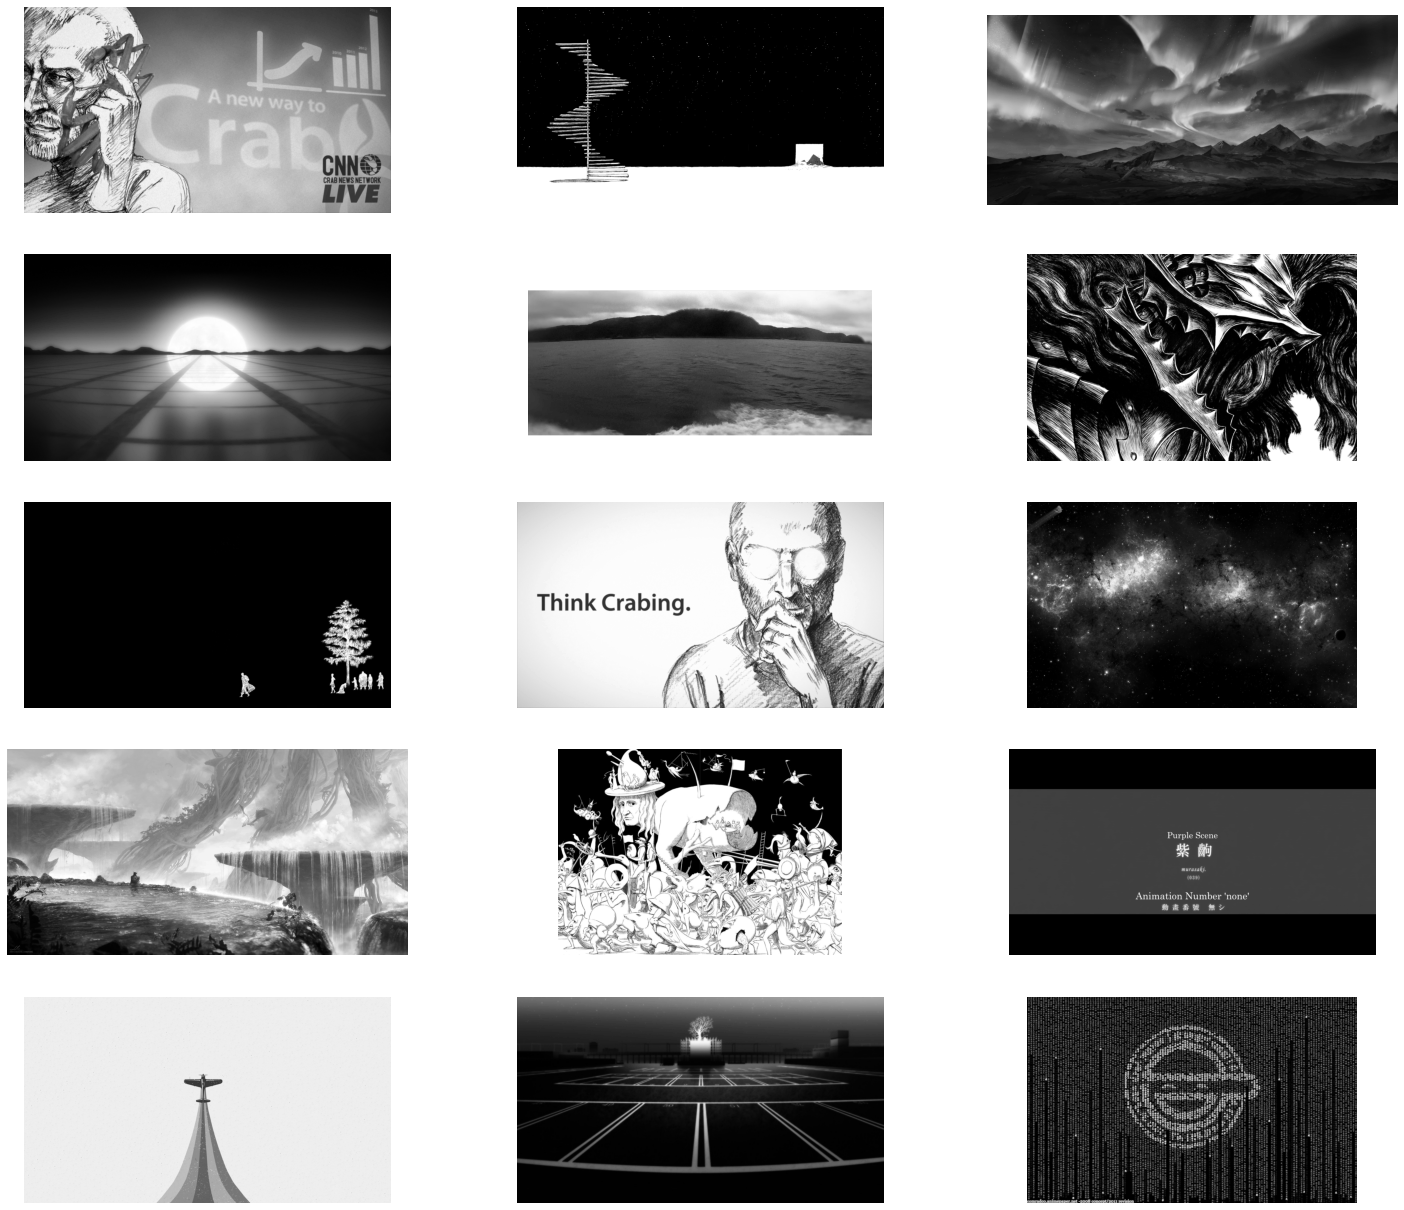

In [6]:
visualize_images(images)

In [7]:
analysis_data = {
    'PCA': {
        'ssim': [], 'transform_t': [], 'inv_t': []
    }, 'IPCA' : {
        'ssim': [], 'transform_t': [], 'inv_t': []
    }
}

In [8]:
for image in images:
    for model_name in ['PCA', 'IPCA']:
        ssim_arr, transform_times, inverse_times = benchmark_model_on_image(model_name, image)
        analysis_data[model_name]['ssim'].append(ssim_arr)
        analysis_data[model_name]['transform_t'].append(transform_times)
        analysis_data[model_name]['inv_t'].append(inverse_times)

Time spent for current fit_transform_PCA iteration is 0.1890 seconds.
Time spent for current inverse_transform_PCA iteration is 0.0073 seconds.
Time spent for current fit_transform_whole_IPCA iteration is 0.5153 seconds.
Time spent for current inverse_transform_whole_IPCA iteration is 0.3983 seconds.
Time spent for current fit_transform_PCA iteration is 0.1291 seconds.
Time spent for current inverse_transform_PCA iteration is 0.0070 seconds.
Time spent for current fit_transform_PCA iteration is 0.2105 seconds.
Time spent for current inverse_transform_PCA iteration is 0.0142 seconds.
Time spent for current fit_transform_PCA iteration is 0.3532 seconds.
Time spent for current inverse_transform_PCA iteration is 0.0173 seconds.
Time spent for current fit_transform_PCA iteration is 0.4815 seconds.
Time spent for current inverse_transform_PCA iteration is 0.0267 seconds.
Time spent for current fit_transform_PCA iteration is 0.5518 seconds.
Time spent for current inverse_transform_PCA iterati

Ниже в первой строке расположены графики, соответствующие `PCA`, во второй - `IPCA`.

По столбцам:

- В первом столбце отображены графики зависимостей значений SSIM от количества компонент. Достаточным является количество компонент, при котором $SSIM > 0.9$.

- Во втором столбце отображены графики зависимостей времени трансформации (операция `fit_transform`) от числа обрабатываемых компонент.

- В третьем столбце отображены графики зависимостей времени обратного преобразования уже преобразованного изображения (операция `inverse_transform`) от числа обрабатываемых компонент.

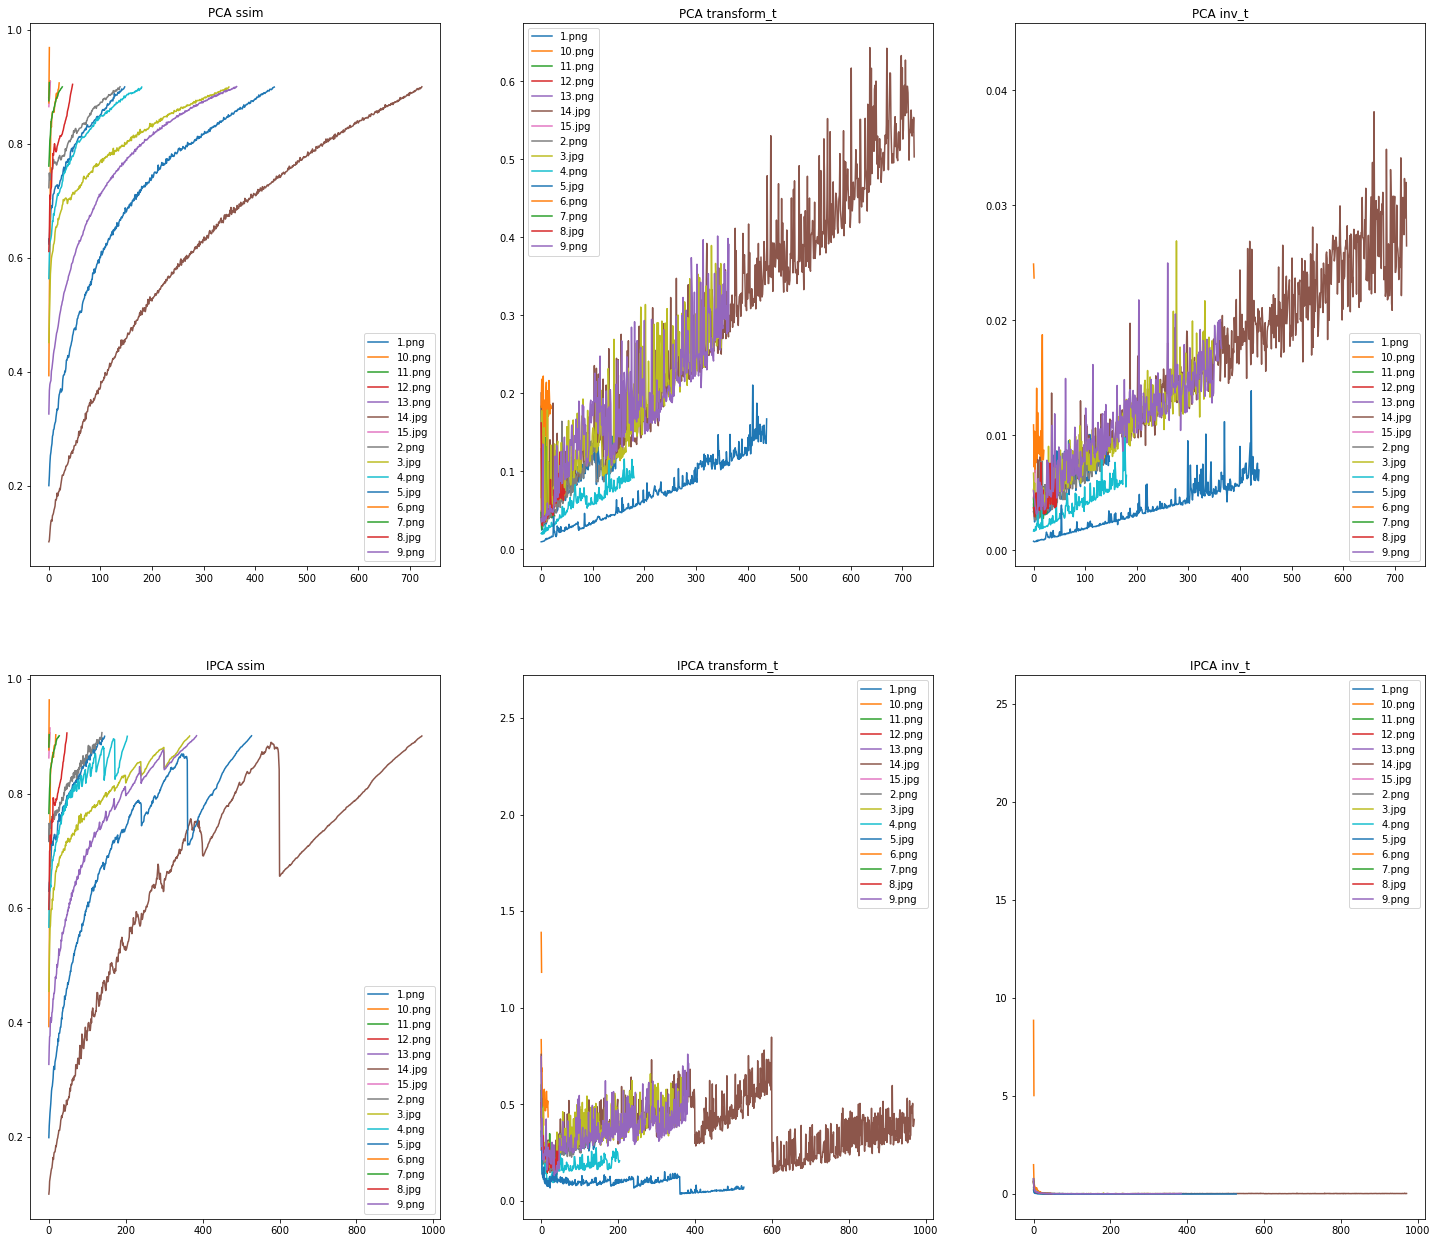

In [17]:
visualize_plots(analysis_data)

## Анализ результатов

Судя по графикам зависимости времени, затраченного на трансформацию и инверсию, от количества компонент для методов `PCA` и `IPCA`, `IPCA` работает примерно в $2-2.5$ раза дольше. Однако, оба метода показывают примерно одинаковую эффективность при классификации изображений, используя схожее (или даже одинаковое!) число компонент для достижения $SSIM > 0.9$. Тот факт, что `IPCA` работает медленнее, является ожидаемым, поскольку метод `IPCA` требует больше времени для обработки данных (загрузки изображения, трансформации и обратного преобразования) по частям, что не является критически необходимым в данной задаче. Можно заметить, что для `IPCA` характерны скачки значений, что так же связано с тем, что изображения там обрабатываются частями. Примечательно, что сопоставимость эффективности этих двух методов делает `IPCA` прекрасным вариантом для случаев, когда объем данных настолько большой, что с помощью `PCA` их обработать невозможно. Как выяснилось, `IPCA` позволит сделать это c приемлемыми потерями точности.

## Заключение

Применив `PCA` и `IPCA` для задачи сжатия изображений и проанализировав результаты, мы приходим к выводу, что при обработке изображений небольшого размера `IPCA` показывает менее высокую производительность. Тем не менее, `IPCA` вполне сопоставим с классическим `PCA` по эффективности. Ознакомление с данным методом на примере несложной задачи может оказаться очень полезным при расcмотрении задач с большими объемами данных, в которых применить `PCA` невозможно.